In [1]:
import os
import pickle
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt

In [2]:
sem_df = pd.read_csv('../data/semmedVER31_R_clean_de-depricate.csv')

/home/mmayers/software/anaconda3/envs/ml/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('Rows: {:,}'.format(sem_df.shape[0]))
print('Cols: {}'.format(sem_df.shape[1]))

Rows: 102,113,685
Cols: 12


In [4]:
sem_df.head()

,PREDICATION_ID,SENTENCE_ID,PMID,PREDICATE,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY
0,38999,87169,4958141,PART_OF,C0040291,Tissue Extracts,bacs,1,C0085979,Cavia,mamm,1
1,39000,87167,13997680,LOCATION_OF,C0005767,Blood,tisu,1,C0007061,Carboxyhemoglobin,aapp,1
2,39001,87171,12254865,PROCESS_OF,C0702166,Acne,dsyn,1,C0043210,Woman,humn,1
3,39002,87175,14847741,PART_OF,C0027809,Neurilemmoma,neop,1,C0038351,Stomach,bpoc,1
4,39003,87165,11396507,PART_OF,C0221921,Stratum corneum,tisu,1,C0086418,Homo sapiens,humn,1


## Count PMIDs

In [5]:
from collections import defaultdict

In [6]:
pmids = defaultdict(set)

for tup in tqdm(sem_df.itertuples(False, None), total=len(sem_df)):
    pmid = tup[2]
    sub = tup[4]
    pred = tup[3]
    obj = tup[8]
    
    pmids[(sub, pred, obj)].add(pmid)

100%|██████████| 102113685/102113685 [05:45<00:00, 295777.74it/s]


In [7]:
pmids[('C0232338', 'PROCESS_OF', 'C0012984')]

{16990217,
 2867218,
 24428565,
 23,
 696351,
 12124197,
 7102508,
 16436,
 3235894,
 9756732,
 786496,
 7594053,
 9863238,
 2138185,
 1441869,
 1269846,
 6864987,
 508009,
 7733353,
 4030591,
 7176320,
 5922945,
 4825221,
 26058891,
 1884300,
 7184524,
 1982609,
 622740,
 270486,
 5324955,
 3440796,
 10027166,
 3342495,
 11247775,
 8357,
 6127791,
 6144176,
 3891380,
 2965695,
 3825857,
 5357762,
 4522182,
 9879753,
 2859210,
 6422733,
 2965715,
 7954653,
 8519902,
 18202845,
 13000928,
 22683869,
 344293,
 1433833,
 6406410,
 1122572,
 6332687,
 15261969,
 2523414,
 1777945,
 7143714,
 500003,
 8929580,
 6881580,
 16892205,
 4587823,
 1597746,
 131380,
 1016119,
 2801977,
 6373692,
 15139132,
 6373694,
 14885185,
 7127361,
 2744655,
 8151388,
 16580958,
 33121,
 12755300,
 3301739,
 844141,
 844147,
 22135160,
 8397178,
 3613053,
 5652866,
 1016195,
 7324037,
 4678026,
 6455694,
 5480847,
 631185,
 3301787,
 3621283,
 6218152,
 688562,
 65975,
 156090,
 1425857,
 5792197,
 6267347,
 

In [8]:
%%time
grpd = sem_df.groupby(['SUBJECT_CUI', 'PREDICATE', 'OBJECT_CUI'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 579 µs


In [9]:
%%time
counts = grpd['PMID'].nunique()

CPU times: user 5min 15s, sys: 1.18 s, total: 5min 16s
Wall time: 5min 15s


In [10]:
counts = counts.to_frame()

In [11]:
counts = counts.reset_index()

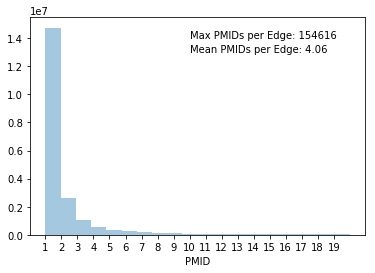

In [12]:
sns.distplot(counts[counts['PMID'] < 21]['PMID'], bins=20, kde=False)
plt.xticks(np.arange(1, 20, 1))
plt.text(10, 1.4e7, 'Max PMIDs per Edge: {}'.format(counts['PMID'].max()))
plt.text(10, 1.3e7, 'Mean PMIDs per Edge: {:1.2f}'.format(counts['PMID'].mean()));

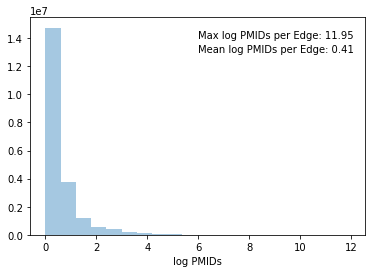

In [13]:
log_counts = np.log(counts['PMID'])
sns.distplot(log_counts, bins=20, kde=False)
plt.xlabel('log PMIDs');
plt.text(6, 1.4e7, 'Max log PMIDs per Edge: {:1.2f}'.format(log_counts.max()))
plt.text(6, 1.3e7, 'Mean log PMIDs per Edge: {:1.2f}'.format(log_counts.mean()));

In [14]:
for i in range(1, 11):
    print("Edges with at least {} unique PMIDs: {:,}".format(i, (counts['PMID'] >= i).sum()))

Edges with at least 1 unique PMIDs: 21,029,688
Edges with at least 2 unique PMIDs: 6,283,545
Edges with at least 3 unique PMIDs: 3,629,774
Edges with at least 4 unique PMIDs: 2,554,514
Edges with at least 5 unique PMIDs: 1,972,421
Edges with at least 6 unique PMIDs: 1,606,535
Edges with at least 7 unique PMIDs: 1,354,464
Edges with at least 8 unique PMIDs: 1,171,227
Edges with at least 9 unique PMIDs: 1,030,991
Edges with at least 10 unique PMIDs: 920,340


## De-Duplicate

The data will be faster to work with if duplicate items are removed.

In [15]:
sem_df = sem_df.drop_duplicates(subset=['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE', 'PREDICATE',
                                        'OBJECT_CUI', 'OBJECT_NAME', 'OBJECT_SEMTYPE'])

print('Rows Remaining: {:,}'.format(sem_df.shape[0]))

Rows Remaining: 21,522,794


# Sem-Types

Semtypes are abbreviated, so need to get mappings to true name.  
Examining the length of the map file, there should be 133 semtypes.

In [16]:
len(set(sem_df['SUBJECT_SEMTYPE'].unique()).union(set(sem_df['OBJECT_SEMTYPE'].unique())))

133

## Normalizing semtypes for CUIs with multiple semtypes

We know that there are multiple Semtypes for a given CUI found throghout the database.  Can we just use a voting system? That with the most occruances of a given semtype gets that semtype?

For a CUI thats a Gene e.g. `C1337111` or the `POMC gene` we want something thats a subclass of Genes and Genomes (aka gngm).

In [17]:
sem_df.query('SUBJECT_CUI == "C1337111"')['SUBJECT_SEMTYPE'].value_counts()

aapp    4275
gngm     913
horm     831
phsu     274
nsba      31
lbpr       1
bacs       1
Name: SUBJECT_SEMTYPE, dtype: int64

Unfortunately, aapp is a sublcass of Chemicals & Drugs, so this would be given the wrong superclass if identified.

However, it will be easier to do this if the nodes are sperated from the edges first


### Semmtypes abbreviation mappings

Files with the mapping information were [downloaded here](https://metamap.nlm.nih.gov/SemanticTypesAndGroups.shtml)

In [18]:
abbv_to_type = dict()
with open('../SemanticTypes_2013AA.txt') as fin:
    for line in fin:
        line = line.strip()
        lspt = line.split('|')
        abbv_to_type[lspt[0]] = lspt[-1]
type_to_abbv = {v:k for k, v in abbv_to_type.items()}

Semtypes also have a supertype.   
The mapping file has this structure:

    ANAT|Anatomy|T017|Anatomical Structure

### Semtype supertypes mappings

In [19]:
abbv_to_super = dict()
with open('../SemGroups_2013.txt') as fin:
    for line in fin:
        line = line.strip()
        lspt = line.split('|')
        abbv_to_super[type_to_abbv[lspt[-1]]] = lspt[1]

### Check to see that all of the semtype abbreviations in the SemmedDB are repepresented in this mapping file

In [20]:
semtype_abbvs = abbv_to_super.keys()
unused_abbvs = set(sem_df.query('SUBJECT_SEMTYPE not in @semtype_abbvs')['SUBJECT_SEMTYPE'].unique())
unused_abbvs.update(set(sem_df.query('OBJECT_SEMTYPE not in @semtype_abbvs')['OBJECT_SEMTYPE'].unique()))

unused_abbvs

{'alga', 'invt', 'rich'}

There are a few that aren't in there (ignore the 0, thats probably a corrupted line), so lets see if we can figure out what they should be

In [21]:
sem_df.query('SUBJECT_SEMTYPE == "alga"').head(2)[['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE']]

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE
3276,C0002032,"Algae, Green",alga
5130,C0002028,Algae,alga


In [22]:
sem_df.query('SUBJECT_SEMTYPE == "invt"').head(2)[['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE']]

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE
187,C0012518,Dipetalonema perstans,invt
294,C0026584,Culicidae,invt


In [23]:
sem_df.query('SUBJECT_SEMTYPE == "rich"').head(2)[['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE']]

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE
1499,C0035587,Rickettsia prowazekii,rich
7037,C0010240,Coxiella burnetii,rich


In [24]:
# Looked ups a few cuis with these and they are all of the living beings type, 
# so we will set these to that semtype
abbv_to_super['invt'] = 'Living Beings'
abbv_to_super['alga'] = 'Living Beings'
abbv_to_super['rich'] = 'Living Beings'

In [25]:
# Make a nodes csv

snodes = pd.DataFrame()
onodes = pd.DataFrame()


snodes['ID'] = sem_df['SUBJECT_CUI']
snodes['name'] = sem_df['SUBJECT_NAME']
snodes['LABEL'] = sem_df['SUBJECT_SEMTYPE'].apply(lambda x: abbv_to_super.get(x))

onodes['ID'] = sem_df['OBJECT_CUI']
onodes['name'] = sem_df['OBJECT_NAME']
onodes['LABEL'] = sem_df['OBJECT_SEMTYPE'].apply(lambda x: abbv_to_super.get(x))


nodes = pd.concat([snodes, onodes])
nodes.drop_duplicates(inplace=True)
nodes = nodes.reset_index(drop=True)

nodes.head()

,ID,name,LABEL
0,C0040291,Tissue Extracts,Chemicals & Drugs
1,C0005767,Blood,Anatomy
2,C0702166,Acne,Disorders
3,C0027809,Neurilemmoma,Disorders
4,C0221921,Stratum corneum,Anatomy


In [26]:
print('There are {} lines and {} unique IDs'.format(nodes.shape[0], nodes['ID'].nunique()))
0
num_duped = nodes[nodes.duplicated(subset='ID', keep=False)].drop_duplicates().shape[0]
print('{} IDs have been found to have multiple semantic types'.format(num_duped))

There are 300192 lines and 262758 unique IDs
73201 IDs have been found to have multiple semantic types


Dropping all NA values drops way too many.  We need to see which ones have NA values and why

In [27]:
no_semtype = nodes.isnull().sum(axis=1).astype(bool)
nodes[no_semtype]

,ID,name,LABEL


In [28]:
cui_to_t_code = dict()
#with open('../MRSTY.RRF') as fin:
with open('../2017AA-full/2017AA/META/MRSTY.RRF') as fin:
    for line in fin:
        line = line.strip()
        ls = line.split('|')
        cui_to_t_code[ls[0]] = [x for x in ls[1:] if x != '']

In [29]:
t_code_to_super = dict()
with open('../SemGroups_2013.txt') as fin:
    for line in fin:
        line = line.strip()
        ls = line.split('|')
        t_code_to_super[ls[2]] = ls[1]

In [30]:
for i, (k, v) in enumerate(cui_to_t_code.items()):
    print(k, v)
    if i==10:
        break

C3484816 ['T121']
C4300096 ['T097']
C2869726 ['T037']
C0282908 ['T121']
C1930742 ['T204']
C0344374 ['T184']
C3769881 ['T007']
C2343866 ['T168']
C2311809 ['T007']
C2175288 ['T033']
C2062346 ['T047']


In [31]:
cui_to_super = dict()
for k, v in cui_to_t_code.items():
    # Only 1 T-Code, so map to its super semmantic type
    if len(v) == 1:
        cui_to_super[k] = t_code_to_super[v[0]]
    else:
        # Most multiple T-Codes should have the same supertype
        v_set = set([t_code_to_super[x] for x in v])
        if len(v_set) == 1:
            cui_to_super[k] = v_set.pop()
        # If they don't have the same supertype, return as a list...
        else:
            # If nothing prints they we have true 1-1 mapping and noting to worry about
            print(k, v_set)
            cui_to_super[k] = list(v_set)

## Re-label the semmantic types to their true type

In [32]:
nodes['true_label'] = nodes['ID'].apply(lambda x: cui_to_super.get(x, x))

In [33]:
p_idx = nodes['true_label'].str.startswith('C')
bad_ids = set(nodes[p_idx]['true_label'])
print("{} CUIs not found for true Semmantic Mapping...".format(len(bad_ids)))

24 CUIs not found for true Semmantic Mapping...


Some node CUIs were not mappable to a semmatic type.  We will use what semmedDB provided for a semantic type in these instances.

In [34]:
potential_problems = nodes.query('ID in @bad_ids').copy()

In [35]:
potential_problems['true_label'] = potential_problems['LABEL']
problems = potential_problems[potential_problems.duplicated(subset='ID', keep=False)].copy()
print("Now {} CUIs have multiple Semmantic Types".format(problems['ID'].nunique()))

Now 12 CUIs have multiple Semmantic Types


In [36]:
fixed_probs = potential_problems.drop(problems.index)

### Combining Multiple semtypes for a single object

Even after direct mapping of CUIs to semtypes, some still have more than one semantic type.

These could potentially be retired CUIs that are no longer used in the current UMLS deployment. For now, we will just resolve them by looking at which two types are showing up for what kind of objects, then making a hierarchy.

In [37]:
pairs = []
grpd = problems.groupby('ID')
for grp, df in grpd:
    pairs.append(tuple(df.sort_values('LABEL')['LABEL']))
pairs = set(pairs)
len(pairs)

1

In [38]:
pairs = sorted(list(pairs))
pairs

[('Chemicals & Drugs', 'Genes & Molecular Sequences')]

In [39]:
def look_at_semtype_pairs(dups, pairs):
    types = dups['LABEL'] == pairs[0]
    for p in pairs[1:]:
        current_type = dups['LABEL'] == p
        types = types | current_type
        
    return dups[types][dups.loc[types, 'ID'].duplicated(keep=False)].sort_values('ID')

In [40]:
first_kind = pairs[0][0]
bad_ids = set(problems.query('true_label == @first_kind')['ID'])
for kind in pairs[0][1:]:
    bad_ids = bad_ids & (set(problems.query('true_label == @kind')['ID']))
bad_id = bad_ids.pop()

problems.query('ID == @bad_id')

,ID,name,LABEL,true_label
247809,C4320013,CERNA1 gene,Genes & Molecular Sequences,Genes & Molecular Sequences
295466,C4320013,CERNA1 gene,Chemicals & Drugs,Chemicals & Drugs


Can't even find the above CUI so will drop from the final Network

Some are genes, some are proteins and some look a bit ambiguous. However, all of these would be classified as 'Genes and Molecular Sequences' in the final network

In [41]:
semtype_hierarchy = [['Genes & Molecular Sequences', 'Chemicals & Drugs']]

In [42]:
def fix_multi_semtype(dups, semtypes):
    
    # Get the duplicates for the given types
    types = dups['LABEL'] == semtypes[0]
    for p in semtypes[1:]:
        current_type = dups['LABEL'] == p
        types = types | current_type
        
    # Only keep those where the ID appears multiple times
    duplicated = dups[types][dups.loc[types, 'ID'].duplicated(keep=False)]
    to_remove = duplicated.index
    duplicated = duplicated.reset_index(drop=True)
    
    
    # Switch to the preferred type
    duplicated['LABEL'] = semtypes[0]
    # Now remove the duplicates
    duplicated = duplicated.drop_duplicates()
    
    # return the fixed data
    return duplicated.reset_index(drop=True), to_remove


In [43]:
fixed_multi_types = []
for pair in semtype_hierarchy:
    fixed, remove = fix_multi_semtype(problems, pair)
    fixed_multi_types.append(fixed)
    problems.drop(remove, inplace=True)
fixed_semtype_df = pd.concat(fixed_multi_types)

In [44]:
fixed_semtype_df['true_label'] = fixed_semtype_df['LABEL']
fixed_semtype_df = fixed_semtype_df.drop_duplicates().reset_index(drop=True)

In [45]:
# Get rid of that bad one that was not findable
idx = fixed_semtype_df.query('ID == @bad_id').index
fixed_semtype_df.drop(idx, inplace=True)

### Recombine all the nodes with the new semmantic types

In [46]:
before_len = len(nodes)
nodes = nodes.drop(potential_problems.index)
nodes = pd.concat([nodes, fixed_probs, fixed_semtype_df])
nodes['LABEL'] = nodes['true_label']
nodes = nodes[['ID', 'name', 'LABEL']].drop_duplicates().reset_index(drop=True)

print("Went from {} to {} nodes by setting semantic type".format(before_len, len(nodes)))
print("{} Unique CUIs".format(nodes['ID'].nunique()))

Went from 300192 to 262757 nodes by setting semantic type
262757 Unique CUIs


In [47]:
print('There are {} nodes with {} unique IDs'.format(nodes.shape[0], nodes['ID'].nunique()))

There are 262757 nodes with 262757 unique IDs


Looks like we finally have a 1:1 relationship of unique IDs to rows in our nodes table

# Edges File

## Prediacate types

[Semmed Docs](https://skr3.nlm.nih.gov/SemMed/jsp/SemMedDocumentation2.pdf)


The docs above show only 26 predicates, lets see how many the data actually contains an and what they are...

In [48]:
print(sem_df['PREDICATE'].nunique())

58


Looks like 58 total predicates.  There are negated predicats, but still, negating all should only yield 52 total.  There are also some that are all lower-case, which do not seem to be found in the documents.

In [49]:
sem_df['PREDICATE'].unique()

array(['PART_OF', 'LOCATION_OF', 'PROCESS_OF', 'ISA', 'COEXISTS_WITH',
       'INTERACTS_WITH', 'TREATS', 'USES', 'METHOD_OF', 'CAUSES',
       'ASSOCIATED_WITH', 'AFFECTS', 'DIAGNOSES', 'PRECEDES',
       'NEG_INHIBITS', 'compared_with', 'ADMINISTERED_TO', 'PREVENTS',
       'OCCURS_IN', 'STIMULATES', 'NEG_ADMINISTERED_TO', 'DISRUPTS',
       'higher_than', 'AUGMENTS', 'INHIBITS', 'COMPLICATES', 'NEG_AFFECTS',
       'PREDISPOSES', 'different_from', 'MANIFESTATION_OF', 'same_as',
       'NEG_higher_than', 'PRODUCES', 'NEG_DISRUPTS', 'NEG_CAUSES',
       'NEG_INTERACTS_WITH', 'NEG_PROCESS_OF', 'NEG_COEXISTS_WITH',
       'NEG_PART_OF', 'NEG_USES', 'lower_than', 'NEG_LOCATION_OF',
       'NEG_METHOD_OF', 'NEG_PREVENTS', 'CONVERTS_TO', 'NEG_AUGMENTS',
       'NEG_DIAGNOSES', 'NEG_PREDISPOSES', 'NEG_TREATS', 'NEG_PRODUCES',
       'NEG_ASSOCIATED_WITH', 'NEG_COMPLICATES', 'NEG_STIMULATES',
       'NEG_OCCURS_IN', 'NEG_CONVERTS_TO', 'NEG_lower_than',
       'NEG_PRECEDES', 'NEG_MANIFESTATI

### Abbreviations

According to rephetio conventions, edges must be written as `EDGETYPE_abbrev` where the abbreviation is START_NODE Abv, Predicate Abv, END_NODE Abv.  for example a Compound that treats a disease is abbreviated TREATS_CtD.  

We must come up with unique abbreviations for each semantic type for the nodes as well as each predicate. These concatinated together will give a unique abbreviation for each edge type.

In [50]:
p_abv = {
 'ADMINISTERED_TO': 'at',
 'AFFECTS': 'af',
 'ASSOCIATED_WITH': 'aw',
 'AUGMENTS': 'ag',
 'CAUSES': 'c',
 'COEXISTS_WITH': 'cw',
 'COMPLICATES': 'cp',
 'CONVERTS_TO': 'ct',
 'DIAGNOSES': 'dg',
 'DISRUPTS': 'ds',
 'INHIBITS': 'in',
 'INTERACTS_WITH': 'iw',
 'ISA': 'i',
 'LOCATION_OF': 'lo',
 'MANIFESTATION_OF': 'mfo',
 'METHOD_OF': 'mo',
 'NEG_ADMINISTERED_TO': 'nat',
 'NEG_AFFECTS': 'naf',
 'NEG_ASSOCIATED_WITH': 'naw',
 'NEG_AUGMENTS': 'nag',
 'NEG_CAUSES': 'nc',
 'NEG_COEXISTS_WITH': 'ncw',
 'NEG_COMPLICATES': 'ncp',
 'NEG_CONVERTS_TO': 'nct',
 'NEG_DIAGNOSES': 'ndg',
 'NEG_DISRUPTS': 'nds',
 'NEG_INHIBITS': 'nin',
 'NEG_INTERACTS_WITH': 'niw',
 'NEG_LOCATION_OF': 'nlo',
 'NEG_MANIFESTATION_OF': 'nmfo',
 'NEG_METHOD_OF': 'nmo',
 'NEG_OCCURS_IN': 'noi',
 'NEG_PART_OF': 'npo',
 'NEG_PRECEDES': 'npc',
 'NEG_PREDISPOSES': 'nps',
 'NEG_PREVENTS': 'npv',
 'NEG_PROCESS_OF': 'npro',
 'NEG_PRODUCES': 'npd',
 'NEG_STIMULATES': 'nst',
 'NEG_TREATS': 'nt',
 'NEG_USES': 'nu',
 'NEG_higher_than': 'nht',
 'NEG_lower_than': 'nlt',
 'OCCURS_IN': 'oi',
 'PART_OF': 'po',
 'PRECEDES': 'pc',
 'PREDISPOSES': 'ps',
 'PREP': 'pr',
 'PREVENTS': 'pv',
 'PROCESS_OF': 'pro',
 'PRODUCES': 'pd',
 'STIMULATES': 'st',
 'TREATS': 't',
 'USES': 'u',
 'compared_with': 'cpw',
 'different_from': 'df',
 'different_than': 'dt',
 'higher_than': 'ht',
 'lower_than': 'lt',
 'same_as': 'sa'}

In [51]:
# get abbreviations for semtypes
super_sems = set(abbv_to_super.values())

len(super_sems)
super_sems

{'Activities & Behaviors',
 'Anatomy',
 'Chemicals & Drugs',
 'Concepts & Ideas',
 'Devices',
 'Disorders',
 'Genes & Molecular Sequences',
 'Geographic Areas',
 'Living Beings',
 'Objects',
 'Occupations',
 'Organizations',
 'Phenomena',
 'Physiology',
 'Procedures'}

In [52]:
# Run these by hand as there are few, and some don't lend themselves well to auto-generation
sem_abv = {
 'Activities & Behaviors': 'AB',
 'Anatomy': 'A',
 'Compound': 'C',
 'Chemicals & Drugs': 'CD',
 'Concepts & Ideas': 'CI',
 'Devices': 'DV',
 'Disease': 'D',
 'Disorders': 'DO',
 'Genes & Molecular Sequences': 'G',
 'Geographic Areas': 'GA',
 'Living Beings': 'LB',
 'Objects': 'OB',
 'Occupations': 'OC',
 'Organizations': 'OR',
 'Phenomena': 'PH',
 'Physiology': 'PS',
 'Procedures': 'PR'
}

# Edge Directions

Most edges may be bi-directions, but some are definitely better exprested as uni-directional.  Here we will classify predicates as bi- or uni-dierectional based on the semantic meaning of the predicate.  Bidirectionl edges have an empty string, whereas uni-directional have a direction marker `'>'`. For example an undirected edge, such as a compound that treats a disease, is written as `TREATS_CtD`. However, a directed edge, like Compound1 converts to Compound 2 would be written as `CONVERTS_TO_Cct>C`.

Edge directions were chosen based on the description found in [this documnetation](https://skr3.nlm.nih.gov/SemMed/jsp/SemMedDocumentation2.pdf).

In [53]:
edge_dir = {
 'ADMINISTERED_TO': '',
 'AFFECTS': '',
 'ASSOCIATED_WITH': '',
 'AUGMENTS': '',
 'CAUSES': '',
 'COEXISTS_WITH': '',
 'COMPLICATES': '',
 'CONVERTS_TO': '>',
 'DIAGNOSES': '',
 'DISRUPTS': '',
 'INHIBITS': '',
 'INTERACTS_WITH': '',
 'ISA': '>',
 'LOCATION_OF': '',
 'MANIFESTATION_OF': '>',
 'METHOD_OF': '',
 'NOM': '',
 'OCCURS_IN': '',
 'PART_OF': '>',
 'PRECEDES': '>',
 'PREDISPOSES': '',
 'PREP': '',
 'PREVENTS': '',
 'PROCESS_OF': '>',
 'PRODUCES': '>',
 'SPEC': '',
 'STIMULATES': '',
 'TREATS': '',
 'USES': '',
 'compared_with': '',
 'different_from': '',
 'different_than': '',
 'higher_from': '',
 'higher_than': '',
 'lower_than': '',
 'same_as': '',
 'than_as': ''}


#for k in p_abv:
#    if k not in edge_dir:
#        edge_dir[k] = edge_dir[k[4:]]
#edge_dir

In [54]:
# Make a mapper from SEMTYPE to sem abbrev
kind_map = {}

for k, v in abbv_to_super.items():
    kind_map[k] = sem_abv[v]

In [55]:
id_to_type = nodes.set_index('ID')['LABEL'].to_dict()
id_to_type_abbv = {k: sem_abv.get(v) for k, v in id_to_type.items()}

In [56]:
edges = pd.DataFrame()

edges['START_ID'] = sem_df['SUBJECT_CUI']
edges['END_ID'] = sem_df['OBJECT_CUI']
edges['TYPE'] = sem_df['PREDICATE']

In [57]:
print(len(edges))
edges = edges.query('TYPE in @p_abv.keys()')
print(len(edges))

21522794
21522794


In [58]:
edges['abbrev'] = (edges['START_ID'].apply(lambda x: id_to_type_abbv.get(x,x)) 
                    + edges['TYPE'].apply(lambda x: p_abv.get(x,x))
                    + edges['TYPE'].apply(lambda x: edge_dir.get(x,''))
                    + edges['END_ID'].apply(lambda x: id_to_type_abbv.get(x,x)))

edges['rev_abbrev'] = (edges['END_ID'].apply(lambda x: id_to_type_abbv.get(x,x)) 
                    + edges['TYPE'].apply(lambda x: edge_dir.get(x,''))
                    + edges['TYPE'].apply(lambda x: p_abv.get(x,x))
                    + edges['START_ID'].apply(lambda x: id_to_type_abbv.get(x,x)))

In [59]:
print(len(edges))
edges = edges.drop_duplicates()
print(len(edges))
edges.head()

21522794
21029688


,START_ID,END_ID,TYPE,abbrev,rev_abbrev
0,C0040291,C0085979,PART_OF,CDpo>LB,LB>poCD
1,C0005767,C0007061,LOCATION_OF,AloCD,CDloA
2,C0702166,C0043210,PROCESS_OF,DOpro>LB,LB>proDO
3,C0027809,C0038351,PART_OF,DOpo>A,A>poDO
4,C0221921,C0086418,PART_OF,Apo>LB,LB>poA


In [60]:
def validate_abbrevs(e_type, abbrev, rev_abbrev):
    if rev_abbrev not in abbreviations:
        abbreviations.update([abbrev])
        return str(e_type) + '_' + str(abbrev)
    else:
        return str(e_type) + '_' + str(rev_abbrev)

In [61]:
%%time
abbreviations = set()
new_types = []
for row in tqdm(edges.itertuples(), total=len(edges)):
    new_types.append(validate_abbrevs(row[3], row[4], row[5]))

100%|██████████| 21029688/21029688 [01:33<00:00, 225910.40it/s]

CPU times: user 1min 32s, sys: 732 ms, total: 1min 33s
Wall time: 1min 33s


In [62]:
edges = edges.reset_index(drop=True)

### Add in the PMID counts as extra data for each edge

In [63]:
len(pmids)

21029688

In [64]:
print(len(edges))

21029688


In [65]:
edges['pmids'] = pd.Series(dtype='object')
for tup in tqdm(edges[['START_ID', 'TYPE', 'END_ID']].itertuples(True, None), total=len(edges)):
    edges.set_value(tup[0], 'pmids', pmids[tup[1:]])

100%|██████████| 21029688/21029688 [04:57<00:00, 70723.64it/s]


### Swap start and end IDs for edges where start and end types were swapped...

In [66]:
e_types_current = edges['TYPE'] + '_' + edges['abbrev']

In [67]:
need_swap = e_types_current != pd.Series(new_types)

In [68]:
tmp = edges.loc[need_swap, 'START_ID']
edges.loc[need_swap, 'START_ID'] = edges.loc[need_swap, 'END_ID']
edges.loc[need_swap, 'END_ID'] = tmp
edges['TYPE'] = new_types

In [69]:
# drop extra columns
edges = edges[['START_ID', 'END_ID', 'TYPE', 'pmids']]

In [70]:
edges['TYPE'].nunique()

2962

In [71]:
%%time
# Some edges now duplicated, de-duplicate and combine pmids
grpd = edges.groupby(['START_ID', 'END_ID', 'TYPE'])
edges = grpd['pmids'].apply(lambda Series: set.union(*Series.values)).reset_index()

CPU times: user 29min 48s, sys: 9.49 s, total: 29min 57s
Wall time: 29min 57s


In [72]:
%%time
# Get the number of pmids
edges['n_pmids'] = edges['pmids'].apply(len)

CPU times: user 6.5 s, sys: 108 ms, total: 6.61 s
Wall time: 6.57 s


In [73]:
nodes = nodes.dropna()

In [74]:
print('{:,}'.format(len(nodes)))
print('{:,}'.format(len(edges)))

262,757
20,753,413


### Ensure that all ids in the edges appear in the nodes

Also make sure that the nodes don't contain any extra IDs not used by the edges

In [75]:
edge_ids = set(edges['START_ID']).union(set(edges['END_ID']))
len(edge_ids)

262758

In [76]:
node_ids = set(nodes['ID'])
len(node_ids)

262757

In [77]:
# ensure there are no edge IDs that are not also in thenodes
len(edge_ids - node_ids)

1

Not sure why there's some nodes that are missing that are in the eges, but he list is small so we will use the UMLS API to retreive the missing values

In [78]:
missing_nodes = set(edge_ids) - node_ids

In [79]:
with open('../data/api.key', 'r') as fin: 
    TICKET = fin.read().rstrip()

In [80]:
import requests
from pyquery import PyQuery as pq

In [81]:
def handshake():
    # insane umls api instructions
    # https://documentation.uts.nlm.nih.gov/rest/authentication.html
    r = requests.post("https://utslogin.nlm.nih.gov/cas/v1/api-key", data={'apikey': TICKET})
    d = pq(r.text)
    tgt = d.find('form').attr('action')
    return tgt

In [82]:
def cui_to_name(cui, tgt):
    """
    given umls cui, get the name
    """
    data = {'service': 'http://umlsks.nlm.nih.gov'}
    r = requests.post(tgt, data=data)
    st = r.text
    url = "https://uts-ws.nlm.nih.gov/rest/content/current/CUI/{}?ticket={}"
    d = requests.get(url.format(cui, st)).json()
    return d['result']['name']

In [83]:
def get_t_codes(cui, tgt):
    """
    given a cui, get the umls semmantic type T code
    """
    data = {'service': 'http://umlsks.nlm.nih.gov'}
    r = requests.post(tgt, data=data)
    st = r.text
    url = "https://uts-ws.nlm.nih.gov/rest/content/current/CUI/{}?ticket={}"
    d = requests.get(url.format(cui, st)).json()
    
    # Extract the Codes
    codes = []
    for t in d['result']['semanticTypes']:
        codes.append(t['uri'].split('/')[-1])
    return codes

In [84]:
def get_sem_type_from_cui(cui, tgt):
    t_codes = get_t_codes(cui, tgt)
    sem_types = set([t_code_to_super[t] for t in t_codes])
    assert len(sem_types) == 1
    return sem_types.pop()

In [85]:
tgt = handshake()

In [86]:
missing_nodes_data = {'ID': [], 'name': [], 'LABEL': []}
for n in missing_nodes:
    missing_nodes_data['ID'].append(n)
    missing_nodes_data['name'].append(cui_to_name(n, tgt))
    missing_nodes_data['LABEL'].append(get_sem_type_from_cui(n, tgt))
    
missing_nodes_data = pd.DataFrame(missing_nodes_data)
missing_nodes_data

,ID,LABEL,name
0,C4320013,Genes & Molecular Sequences,CERNA1 gene


In [87]:
nodes = pd.concat([nodes, missing_nodes_data]).sort_values('ID').reset_index(drop=True)

In [88]:
# remove nodes that don't appear in the edges
edge_ids = list(edge_ids)
nodes = nodes.query('ID in @edge_ids')

In [89]:
nodes['ID'].nunique()

262758

In [90]:
# Sort values before writing to disk
nodes = nodes.sort_values('LABEL')
edges = edges.sort_values('TYPE')

# Add in colons required by neo4j
nodes = nodes.rename(columns={'ID': ':ID', 'LABEL': ':LABEL'})
edges = edges.rename(columns={'START_ID': ':START_ID', 'END_ID': ':END_ID', 'TYPE': ':TYPE'})

nodes.to_csv('../data/nodes_VER31_R.csv', index=False)
edges.to_csv('../data/edges_VER31_R.csv', index=False)